In [1]:
import os
import sys
import pymysql
import re
import time
import pandas as pd
import numpy as np
import category_encoders as ce
import joblib
import featuretools as ft
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt

from Utils.bulk_insert import BulkInsert
from Config import params_config, db_config, queries_config

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [3]:
db_params = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'daigo1123',
    'database': 'dev_netkeiba',
    'port': 3306,
    'charset': 'utf8'
}
con = pymysql.connect(**db_params)
parameters = params_config.parameters
queries = queries_config.queries

## Extract Data from DB

In [4]:
def _fetchall_and_make_list_by(query, con):
    try:
        cursor = con.cursor()
        cursor.execute(query)
        fetch_result = cursor.fetchall()
        fetch_result_list = [item for item in fetch_result]
        cursor.close()
        return fetch_result_list
    except Exception as e:
        print(e)

In [5]:
def _get_race_master_data_frame(queries, parameters, con):
    race_master_list = _fetchall_and_make_list_by(queries['RACE_MASTER_INFO'], con)
    return pd.DataFrame(race_master_list, 
                                         columns=parameters['DATAFRAME_COL_NAMES']['RACE_MASTER_INFO_COLS'])

In [6]:
def _get_race_table_result_data_frame(queries, parameters, con):
    race_table_result_list = _fetchall_and_make_list_by(queries['RACE_TABLE_RESULT_INFO'], con)
    return pd.DataFrame(race_table_result_list, 
                                         columns=parameters['DATAFRAME_COL_NAMES']['RACE_TABLE_RESULT_INFO_COLS'])

In [7]:
def _get_race_past_x_result_data_frame(queries, parameters, con):
    race_past_x_result_list = _fetchall_and_make_list_by(queries['RACE_PAST_X_RESULT_INFO'], con)
    return pd.DataFrame(race_past_x_result_list, 
                                         columns=parameters['DATAFRAME_COL_NAMES']['RACE_PAST_X_RESULT_INFO_COLS'])

In [8]:
race_master_df = _get_race_master_data_frame(queries, parameters, con)

In [9]:
race_table_result_df = _get_race_table_result_data_frame(queries, parameters, con)

In [10]:
race_past_x_result_df = _get_race_past_x_result_data_frame(queries, parameters, con)

## Define index variable and objective variable

In [11]:
def _make_race_horse_id(row):
    horse_num_str = str(row['horse_num']) if row['horse_num'] >= 10 else '0' + str(row['horse_num'])
    return row['race_id'] + '_' + horse_num_str

In [12]:
def preprocess_race_table_result_df_idx(df):
    df['race_horse_id']= df.apply(_make_race_horse_id, axis=1)
    return df

In [13]:
def preprocess_target_variable(df):
    df['y']= df.apply(_define_target_variable, axis=1, model_type='win', obj_type='odds_or_zero')
    return df

In [14]:
def _define_target_variable(row, model_type='win', obj_type='odds_or_zero'):
    if model_type == 'win' and obj_type == 'odds_or_zero':
        if row['arrival_order'] == 1 or row['arrival_sec_diff_from_first'] <= 0.002:
            return row['win_odds']
        else:
            return 0

In [15]:
race_table_result_df = preprocess_race_table_result_df_idx(race_table_result_df)
race_table_result_df = preprocess_target_variable(race_table_result_df)

In [16]:
def _make_race_horse_past_x_id(row):
    horse_num_str = str(row['horse_num']) if row['horse_num'] >= 10 else '0' + str(row['horse_num'])
    return row['race_id'] + '_' + horse_num_str + '_' + str(row['past_x'])

In [17]:
def preprocess_race_past_x_result_df_idx(df):
    df['race_horse_id']= df.apply(_make_race_horse_id, axis=1)
    df['race_horse_past_x_id']= df.apply(_make_race_horse_past_x_id, axis=1)
    return df

In [18]:
race_past_x_result_df = preprocess_race_past_x_result_df_idx(race_past_x_result_df)

#### Check data frame

In [19]:
print(race_master_df.shape)
race_master_df.head()

(40389, 15)


,race_id,race_round,race_kai,race_place,race_corse_baba,race_corse_dist,race_corse_mawari,race_weather,race_condition,race_year,race_month,race_date,race_dow,starting_hour,starting_minutes
0,200801010101,1,1,札幌,芝,1500,右,曇,良,2008,8,16,土,10,40
1,200801010102,2,1,札幌,ダ,1000,右,曇,稍重,2008,8,16,土,11,10
2,200801010103,3,1,札幌,ダ,1700,右,曇,稍重,2008,8,16,土,11,40
3,200801010104,4,1,札幌,芝,1500,右,曇,良,2008,8,16,土,12,30
4,200801010105,5,1,札幌,ダ,1700,右,曇,稍重,2008,8,16,土,13,5


In [20]:
print(race_table_result_df.shape)
race_table_result_df.head()

(572973, 15)


,race_id,horse_num,bracket_num,href_to_horse,horse_age,horse_sex,weight_penalty,href_to_jockey,href_to_owner,popularity_order,win_odds,arrival_sec_diff_from_first,arrival_order,race_horse_id,y
0,200801010101,6,4,https://db.netkeiba.com/horse/2006102194/,2,牝,54.0,https://db.netkeiba.com/jockey/00700/,https://db.netkeiba.com/trainer/01027/,2,4.3,NaN,1,200801010101_06,4.3
1,200801010101,14,8,https://db.netkeiba.com/horse/2006101653/,2,牡,54.0,https://db.netkeiba.com/jockey/00705/,https://db.netkeiba.com/trainer/01099/,4,5.2,0.007,2,200801010101_14,0.0
2,200801010101,1,1,https://db.netkeiba.com/horse/2006104966/,2,牡,54.0,https://db.netkeiba.com/jockey/00945/,https://db.netkeiba.com/trainer/01059/,1,3.1,0.008,3,200801010101_01,0.0
3,200801010101,11,7,https://db.netkeiba.com/horse/2006102534/,2,牡,54.0,https://db.netkeiba.com/jockey/00722/,https://db.netkeiba.com/trainer/00388/,8,23.0,0.010,4,200801010101_11,0.0
4,200801010101,2,2,https://db.netkeiba.com/horse/2006110090/,2,牝,54.0,https://db.netkeiba.com/jockey/01084/,https://db.netkeiba.com/trainer/00419/,6,21.9,0.010,5,200801010101_02,0.0


In [21]:
print(race_past_x_result_df.shape)
race_past_x_result_df.head()

(1972663, 7)


,race_id,horse_num,past_x,past_x_arrival_order,arrival_sec_diff_from_first,race_horse_id,race_horse_past_x_id
0,200801010101,1,1,3,0.003,200801010101_01,200801010101_01_1
1,200801010101,2,1,9,1.677,200801010101_02,200801010101_02_1
2,200801010101,3,1,3,0.990,200801010101_03,200801010101_03_1
3,200801010101,3,2,2,0.992,200801010101_03,200801010101_03_2
4,200801010101,4,1,5,1.667,200801010101_04,200801010101_04_1


## ここまでがデータ固有の前処理,　以降はAutoProcessing

In [22]:
model_params = {    
    'CATEGORICAL_FEATURES_DICT': {
        'race_place': 'OrdinalEncoder',
        'race_corse_baba': 'OrdinalEncoder',
        'race_corse_mawari': 'OrdinalEncoder',
        'race_weather': 'OrdinalEncoder',
        'race_condition': 'OrdinalEncoder',
        'race_dow': 'OrdinalEncoder',
        
        'href_to_horse': 'LeaveOneOutEncoder',
        'horse_sex': 'OrdinalEncoder',
        'href_to_jockey': 'LeaveOneOutEncoder',
        'href_to_owner': 'LeaveOneOutEncoder',
        
        'target_y': 'y'
    },
    
    'FEATURETOOLS_PARAMS': {
        'INDEX_COL': {
            'RACE_MASTER': ['race_id'],
            'RACE_TABLE_RESULT': ['race_id', 'race_horse_id'],
            'RACE_PAST_X_RESULT': ['race_horse_id', 'race_horse_past_x_id']
        },
        'FEATURE_COL': {
            'RACE_MASTER': [
                'race_round',
                'race_kai',
                'race_place',
                'race_corse_baba',
                'race_corse_dist',
                'race_corse_mawari',
                'race_weather',
                'race_condition',
                'race_year',
                'race_month',
                'race_date',
                'race_dow',
                'starting_hour',
                'starting_minutes'
            ],
            'RACE_TABLE_RESULT': [
                'bracket_num',
                'href_to_horse',
                'horse_age',
                'horse_sex',
                'weight_penalty',
                'href_to_jockey',
                'href_to_owner',
                'popularity_order',
                'win_odds'
            ],
            'RACE_PAST_X_RESULT': [
                'past_x_arrival_order',
                'arrival_sec_diff_from_first'
            ]
        },
        'PRIMITIVES': {
            'aggregation': ['sum', 'mean', 'std', 'max', 'min', 'count', 'skew'],
            'transform': []
        }
    },
    
    'TRAIN_TEST_SPLIT': {
        'INDEX_COL': ['race_id', 'horse_num'],
        'EXCLUDE_COL': ['race_id', 'horse_num', 'y'],
        'TARGET_COL': 'y',
        'CRITERIA_TO_SPLIT_DATA': {'race_master.race_year': 2019, 'race_master.race_month': 3}
    }
    
}

## Encoding categorical features
- 参考URL: https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31

In [23]:
def encode_category_variables(df, model_params):
    for key, value in model_params['CATEGORICAL_FEATURES_DICT'].items():        
        if key not in df.columns:
            continue
        if value == 'OrdinalEncoder':
            ce_oe = ce.OrdinalEncoder(cols=key, handle_unknown='impute')
            df = ce_oe.fit_transform(df)
        elif value == 'OneHotEncoder':
            ce_ohe = ce.OneHotEncoder(cols=key, handle_unknown='impute')
            df = ce_ohe.fit_transform(df)            
        elif value == 'LeaveOneOutEncoder':
            ce_looe = ce.LeaveOneOutEncoder(cols=key, handle_unknown='impute')
            df = ce_looe.fit_transform(df, y=df[model_params['CATEGORICAL_FEATURES_DICT']['target_y']])
    return df

In [24]:
race_master_df = encode_category_variables(race_master_df, model_params)
print(race_master_df.shape)
race_master_df.head()

(40389, 15)


,race_id,race_round,race_kai,race_place,race_corse_baba,race_corse_dist,race_corse_mawari,race_weather,race_condition,race_year,race_month,race_date,race_dow,starting_hour,starting_minutes
0,200801010101,1,1,1,1,1500,1,1,1,2008,8,16,1,10,40
1,200801010102,2,1,1,2,1000,1,1,2,2008,8,16,1,11,10
2,200801010103,3,1,1,2,1700,1,1,2,2008,8,16,1,11,40
3,200801010104,4,1,1,1,1500,1,1,1,2008,8,16,1,12,30
4,200801010105,5,1,1,2,1700,1,1,2,2008,8,16,1,13,5


In [25]:
race_table_result_df = encode_category_variables(race_table_result_df, model_params)
print(race_table_result_df.shape)
race_table_result_df.head()

(572973, 15)


,race_id,horse_num,bracket_num,href_to_horse,horse_age,horse_sex,weight_penalty,href_to_jockey,href_to_owner,popularity_order,win_odds,arrival_sec_diff_from_first,arrival_order,race_horse_id,y
0,200801010101,6,4,1.936364,2,1,54.0,1.600226,1.537136,2,4.3,NaN,1,200801010101_06,4.3
1,200801010101,14,8,3.280000,2,2,54.0,1.498720,1.743721,4,5.2,0.007,2,200801010101_14,0.0
2,200801010101,1,1,2.094118,2,2,54.0,1.348950,1.474317,1,3.1,0.008,3,200801010101_01,0.0
3,200801010101,11,7,0.511111,2,2,54.0,1.210191,1.343837,8,23.0,0.010,4,200801010101_11,0.0
4,200801010101,2,2,2.493333,2,1,54.0,1.273362,1.538857,6,21.9,0.010,5,200801010101_02,0.0


In [26]:
race_past_x_result_df = encode_category_variables(race_past_x_result_df, model_params)
print(race_past_x_result_df.shape)
race_past_x_result_df.head()

(1972663, 7)


,race_id,horse_num,past_x,past_x_arrival_order,arrival_sec_diff_from_first,race_horse_id,race_horse_past_x_id
0,200801010101,1,1,3,0.003,200801010101_01,200801010101_01_1
1,200801010101,2,1,9,1.677,200801010101_02,200801010101_02_1
2,200801010101,3,1,3,0.990,200801010101_03,200801010101_03_1
3,200801010101,3,2,2,0.992,200801010101_03,200801010101_03_2
4,200801010101,4,1,5,1.667,200801010101_04,200801010101_04_1


## Feature Engeneering by 'featuretools'
- 参考URL <br>
: https://qiita.com/Hyperion13fleet/items/4eaca365f28049fe11c7 <br>
: https://docs.featuretools.com/en/stable/generated/featuretools.dfs.html#featuretools.dfs

In [27]:
# # Check the primitives
# ft.primitives.list_primitives()
# # print(ft.primitives.list_primitives().iloc[4,2])

In [28]:
def decode_race_horse_id(feature_matrix_df):
    def get_race_id(row):
        race_id = re.split('_', row['race_horse_id'])[0]
        return race_id

    def get_horse_num(row):
        horse_num = int(re.split('_', row['race_horse_id'])[1])
        return horse_num

    table_index_df = pd.DataFrame()
    table_index_df['race_id'] = pd.DataFrame(feature_matrix_df.index).apply(get_race_id, axis=1)
    table_index_df['horse_num'] = pd.DataFrame(feature_matrix_df.index).apply(get_horse_num, axis=1)
    return table_index_df

In [29]:
def engineer_features_by_featuretools(model_params, race_master_df, race_table_result_df, race_past_x_result_df):
    es = ft.EntitySet(id='netkeiba')
    es.entity_from_dataframe(entity_id='race_master', 
                                                    dataframe=race_master_df[model_params['FEATURETOOLS_PARAMS']['INDEX_COL']['RACE_MASTER'] + 
                                                                                                      model_params['FEATURETOOLS_PARAMS']['FEATURE_COL']['RACE_MASTER']], 
                                                    index='race_id')
    es.entity_from_dataframe(entity_id='race_table', 
                                                   dataframe=race_table_result_df[model_params['FEATURETOOLS_PARAMS']['INDEX_COL']['RACE_TABLE_RESULT'] + 
                                                                                                              model_params['FEATURETOOLS_PARAMS']['FEATURE_COL']['RACE_TABLE_RESULT']], 
                                                   index='race_horse_id')
    es.entity_from_dataframe(entity_id='race_past_x', 
                                                   dataframe=race_past_x_result_df[model_params['FEATURETOOLS_PARAMS']['INDEX_COL']['RACE_PAST_X_RESULT'] + 
                                                                                                                 model_params['FEATURETOOLS_PARAMS']['FEATURE_COL']['RACE_PAST_X_RESULT']], 
                                                   index='race_horse_past_x_id')

    r_master_table = ft.Relationship(es['race_master']['race_id'], es['race_table']['race_id'])
    r_table_past_x = ft.Relationship(es['race_table']['race_horse_id'], es['race_past_x']['race_horse_id'])

    es.add_relationships(relationships=[r_master_table])
    es.add_relationships(relationships=[r_table_past_x])    
    
    feature_matrix_df, _ = ft.dfs(
                                                     entityset=es,
                                                     target_entity='race_table',
                                                     agg_primitives=model_params['FEATURETOOLS_PARAMS']['PRIMITIVES']['aggregation'],
                                                     trans_primitives =model_params['FEATURETOOLS_PARAMS']['PRIMITIVES']['transform'],
                                                     max_depth=2
                                                   )
    feature_matrix_df  = feature_matrix_df.fillna(0)
    table_index_df = decode_race_horse_id(feature_matrix_df)
    feature_matrix_df = feature_matrix_df.reset_index(drop=True)
    return feature_matrix_df, table_index_df

In [30]:
feature_matrix_df, table_index_df  = engineer_features_by_featuretools(
    model_params, race_master_df, race_table_result_df, race_past_x_result_df
)

In [31]:
print(table_index_df.shape)
print(feature_matrix_df.shape)
feature_matrix_df.head(10)

(572973, 2)
(572973, 105)


,race_id,bracket_num,href_to_horse,horse_age,horse_sex,weight_penalty,href_to_jockey,href_to_owner,popularity_order,win_odds,SUM(race_past_x.arrival_sec_diff_from_first),SUM(race_past_x.past_x_arrival_order),MEAN(race_past_x.arrival_sec_diff_from_first),MEAN(race_past_x.past_x_arrival_order),STD(race_past_x.arrival_sec_diff_from_first),STD(race_past_x.past_x_arrival_order),MAX(race_past_x.arrival_sec_diff_from_first),MAX(race_past_x.past_x_arrival_order),MIN(race_past_x.arrival_sec_diff_from_first),MIN(race_past_x.past_x_arrival_order),COUNT(race_past_x),SKEW(race_past_x.arrival_sec_diff_from_first),SKEW(race_past_x.past_x_arrival_order),race_master.race_round,race_master.race_kai,race_master.race_place,race_master.race_corse_baba,race_master.race_corse_dist,race_master.race_corse_mawari,race_master.race_weather,race_master.race_condition,race_master.race_year,race_master.race_month,race_master.race_date,race_master.race_dow,race_master.starting_hour,race_master.starting_minutes,race_master.SUM(race_table.href_to_jockey),race_master.SUM(race_table.weight_penalty),race_master.SUM(race_table.bracket_num),race_master.SUM(race_table.win_odds),race_master.SUM(race_table.popularity_order),race_master.SUM(race_table.horse_sex),race_master.SUM(race_table.href_to_owner),race_master.SUM(race_table.horse_age),race_master.SUM(race_table.href_to_horse),race_master.MEAN(race_table.href_to_jockey),race_master.MEAN(race_table.weight_penalty),race_master.MEAN(race_table.bracket_num),race_master.MEAN(race_table.win_odds),race_master.MEAN(race_table.popularity_order),race_master.MEAN(race_table.horse_sex),race_master.MEAN(race_table.href_to_owner),race_master.MEAN(race_table.horse_age),race_master.MEAN(race_table.href_to_horse),race_master.STD(race_table.href_to_jockey),race_master.STD(race_table.weight_penalty),race_master.STD(race_table.bracket_num),race_master.STD(race_table.win_odds),race_master.STD(race_table.popularity_order),race_master.STD(race_table.horse_sex),race_master.STD(race_table.href_to_owner),race_master.STD(race_table.horse_age),race_master.STD(race_table.href_to_horse),race_master.MAX(race_table.href_to_jockey),race_master.MAX(race_table.weight_penalty),race_master.MAX(race_table.bracket_num),race_master.MAX(race_table.win_odds),race_master.MAX(race_table.popularity_order),race_master.MAX(race_table.horse_sex),race_master.MAX(race_table.href_to_owner),race_master.MAX(race_table.horse_age),race_master.MAX(race_table.href_to_horse),race_master.MIN(race_table.href_to_jockey),race_master.MIN(race_table.weight_penalty),race_master.MIN(race_table.bracket_num),race_master.MIN(race_table.win_odds),race_master.MIN(race_table.popularity_order),race_master.MIN(race_table.horse_sex),race_master.MIN(race_table.href_to_owner),race_master.MIN(race_table.horse_age),race_master.MIN(race_table.href_to_horse),race_master.COUNT(race_table),race_master.SKEW(race_table.href_to_jockey),race_master.SKEW(race_table.weight_penalty),race_master.SKEW(race_table.bracket_num),race_master.SKEW(race_table.win_odds),race_master.SKEW(race_table.popularity_order),race_master.SKEW(race_table.horse_sex),race_master.SKEW(race_table.href_to_owner),race_master.SKEW(race_table.horse_age),race_master.SKEW(race_table.href_to_horse),race_master.SUM(race_past_x.arrival_sec_diff_from_first),race_master.SUM(race_past_x.past_x_arrival_order),race_master.MEAN(race_past_x.arrival_sec_diff_from_first),race_master.MEAN(race_past_x.past_x_arrival_order),race_master.STD(race_past_x.arrival_sec_diff_from_first),race_master.STD(race_past_x.past_x_arrival_order),race_master.MAX(race_past_x.arrival_sec_diff_from_first),race_master.MAX(race_past_x.past_x_arrival_order),race_master.MIN(race_past_x.arrival_sec_diff_from_first),race_master.MIN(race_past_x.past_x_arrival_order),race_master.COUNT(race_past_x),race_master.SKEW(race_past_x.arrival_sec_diff_from_first),race_master.SKEW(race_past_x.past_x_arrival_order)
0,200801010101,4,1.936364,2,1,54.0,1.600226,1.537136,2,4.3,0.008,5.0,0.00

## Feature Selection by 'boruta'
- 参考URL: https://dev.classmethod.jp/machine-learning/yoshim-featuretools-boruta-optuna/

### Train Test Split

In [32]:
def make_train_test_data(feature_df, y_df, idx_df, model_params):
    dataset = pd.concat([feature_df, y_df[model_params['TRAIN_TEST_SPLIT']['TARGET_COL']]], axis='columns')
    dataset = pd.concat([idx_df, dataset], axis='columns')
    
    index_cols = model_params['TRAIN_TEST_SPLIT']['INDEX_COL']
    feature_cols = [col for col in list(dataset.columns) if col not in model_params['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
    target_col = model_params['TRAIN_TEST_SPLIT']['TARGET_COL']
    criteria_to_split_dict = model_params['TRAIN_TEST_SPLIT']['CRITERIA_TO_SPLIT_DATA']
    
    Idx_train = dataset[
        (dataset[list(criteria_to_split_dict)[0]] < criteria_to_split_dict[list(criteria_to_split_dict)[0]]) |
        (dataset[list(criteria_to_split_dict)[1]] < criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][index_cols]
    Idx_train = Idx_train.loc[:,~Idx_train.columns.duplicated()]

    X_train = dataset[
        (dataset[list(criteria_to_split_dict)[0]] < criteria_to_split_dict[list(criteria_to_split_dict)[0]]) |
        (dataset[list(criteria_to_split_dict)[1]] < criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][feature_cols]

    y_train = dataset[
        (dataset[list(criteria_to_split_dict)[0]] < criteria_to_split_dict[list(criteria_to_split_dict)[0]]) |
        (dataset[list(criteria_to_split_dict)[1]] < criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][target_col]

    Idx_test = dataset[
        (dataset[list(criteria_to_split_dict)[0]] >= criteria_to_split_dict[list(criteria_to_split_dict)[0]]) &
        (dataset[list(criteria_to_split_dict)[1]] >= criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][index_cols]
    Idx_test = Idx_test.loc[:,~Idx_test.columns.duplicated()]

    X_test = dataset[
        (dataset[list(criteria_to_split_dict)[0]] >= criteria_to_split_dict[list(criteria_to_split_dict)[0]]) &
        (dataset[list(criteria_to_split_dict)[1]] >= criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][feature_cols]

    y_test = dataset[
        (dataset[list(criteria_to_split_dict)[0]] >= criteria_to_split_dict[list(criteria_to_split_dict)[0]]) &
        (dataset[list(criteria_to_split_dict)[1]] >= criteria_to_split_dict[list(criteria_to_split_dict)[1]])
    ][target_col]
    
    return Idx_train, X_train, y_train, Idx_test, X_test, y_test

In [33]:
Idx_train, X_train, y_train, Idx_test, X_test, y_test = make_train_test_data(
    feature_matrix_df, race_table_result_df, table_index_df, model_params
)

In [34]:
print(Idx_train.shape)
print(X_train.shape)
print(y_train.shape)

print(Idx_test.shape)
print(X_test.shape)
print(y_test.shape)

(537701, 2)
(537701, 104)
(537701,)
(35272, 2)
(35272, 104)
(35272,)


In [35]:
X_train.head()

,bracket_num,href_to_horse,horse_age,horse_sex,weight_penalty,href_to_jockey,href_to_owner,popularity_order,win_odds,SUM(race_past_x.arrival_sec_diff_from_first),SUM(race_past_x.past_x_arrival_order),MEAN(race_past_x.arrival_sec_diff_from_first),MEAN(race_past_x.past_x_arrival_order),STD(race_past_x.arrival_sec_diff_from_first),STD(race_past_x.past_x_arrival_order),MAX(race_past_x.arrival_sec_diff_from_first),MAX(race_past_x.past_x_arrival_order),MIN(race_past_x.arrival_sec_diff_from_first),MIN(race_past_x.past_x_arrival_order),COUNT(race_past_x),SKEW(race_past_x.arrival_sec_diff_from_first),SKEW(race_past_x.past_x_arrival_order),race_master.race_round,race_master.race_kai,race_master.race_place,race_master.race_corse_baba,race_master.race_corse_dist,race_master.race_corse_mawari,race_master.race_weather,race_master.race_condition,race_master.race_year,race_master.race_month,race_master.race_date,race_master.race_dow,race_master.starting_hour,race_master.starting_minutes,race_master.SUM(race_table.href_to_jockey),race_master.SUM(race_table.weight_penalty),race_master.SUM(race_table.bracket_num),race_master.SUM(race_table.win_odds),race_master.SUM(race_table.popularity_order),race_master.SUM(race_table.horse_sex),race_master.SUM(race_table.href_to_owner),race_master.SUM(race_table.horse_age),race_master.SUM(race_table.href_to_horse),race_master.MEAN(race_table.href_to_jockey),race_master.MEAN(race_table.weight_penalty),race_master.MEAN(race_table.bracket_num),race_master.MEAN(race_table.win_odds),race_master.MEAN(race_table.popularity_order),race_master.MEAN(race_table.horse_sex),race_master.MEAN(race_table.href_to_owner),race_master.MEAN(race_table.horse_age),race_master.MEAN(race_table.href_to_horse),race_master.STD(race_table.href_to_jockey),race_master.STD(race_table.weight_penalty),race_master.STD(race_table.bracket_num),race_master.STD(race_table.win_odds),race_master.STD(race_table.popularity_order),race_master.STD(race_table.horse_sex),race_master.STD(race_table.href_to_owner),race_master.STD(race_table.horse_age),race_master.STD(race_table.href_to_horse),race_master.MAX(race_table.href_to_jockey),race_master.MAX(race_table.weight_penalty),race_master.MAX(race_table.bracket_num),race_master.MAX(race_table.win_odds),race_master.MAX(race_table.popularity_order),race_master.MAX(race_table.horse_sex),race_master.MAX(race_table.href_to_owner),race_master.MAX(race_table.horse_age),race_master.MAX(race_table.href_to_horse),race_master.MIN(race_table.href_to_jockey),race_master.MIN(race_table.weight_penalty),race_master.MIN(race_table.bracket_num),race_master.MIN(race_table.win_odds),race_master.MIN(race_table.popularity_order),race_master.MIN(race_table.horse_sex),race_master.MIN(race_table.href_to_owner),race_master.MIN(race_table.horse_age),race_master.MIN(race_table.href_to_horse),race_master.COUNT(race_table),race_master.SKEW(race_table.href_to_jockey),race_master.SKEW(race_table.weight_penalty),race_master.SKEW(race_table.bracket_num),race_master.SKEW(race_table.win_odds),race_master.SKEW(race_table.popularity_order),race_master.SKEW(race_table.horse_sex),race_master.SKEW(race_table.href_to_owner),race_master.SKEW(race_table.horse_age),race_master.SKEW(race_table.href_to_horse),race_master.SUM(race_past_x.arrival_sec_diff_from_first),race_master.SUM(race_past_x.past_x_arrival_order),race_master.MEAN(race_past_x.arrival_sec_diff_from_first),race_master.MEAN(race_past_x.past_x_arrival_order),race_master.STD(race_past_x.arrival_sec_diff_from_first),race_master.STD(race_past_x.past_x_arrival_order),race_master.MAX(race_past_x.arrival_sec_diff_from_first),race_master.MAX(race_past_x.past_x_arrival_order),race_master.MIN(race_past_x.arrival_sec_diff_from_first),race_master.MIN(race_past_x.past_x_arrival_order),race_master.COUNT(race_past_x),race_master.SKEW(race_past_x.arrival_sec_diff_from_first),race_master.SKEW(race_past_x.past_x_arrival_order)
0,4,1.936364,2,1,54.0,1.600226,1.537136,2,4.3,0.008,5.0,0.004,2.5,0.001414,0.7071

### Boruta

In [36]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# import matplotlib.pyplot as plt
# import seaborn as sns

In [37]:
def select_features_by_boruta(X_train, X_test, y_train):
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=5,
        max_features='sqrt',
        n_jobs=-1,
        verbose=True,
        random_state=1
    )

    features_selector = BorutaPy(
        model,
        n_estimators='auto',
        perc=80,
        verbose=2,
        two_step=False,
        max_iter=100,
        random_state=1
    )
    
    features_selector.fit(X_train.values, y_train.values)
    X_train_selected = X_train.iloc[:,features_selector.support_]
    X_test_selected = X_test.iloc[:,features_selector.support_]
    feature_selected_cols = list(X_train_selected.columns)
    
    return feature_selected_cols, X_train_selected, X_test_selected

In [38]:
feature_selected_cols, X_train_selected, X_test_selected = select_features_by_boruta(X_train, X_test, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.2min finished


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	104
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	46
Rejected: 	50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  2.0min finished


Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	46
Rejected: 	50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  2.0min finished


Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	46
Rejected: 	50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  2.0min finished


Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	46
Rejected: 	50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:  2.0min finished


Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	37
Rejected: 	59


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.7min finished


Iteration: 	17 / 100
Confirmed: 	8
Tentative: 	37
Rejected: 	59


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.7min finished


Iteration: 	18 / 100
Confirmed: 	8
Tentative: 	37
Rejected: 	59


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.8min finished


Iteration: 	19 / 100
Confirmed: 	8
Tentative: 	34
Rejected: 	62


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  1.7min finished


Iteration: 	20 / 100
Confirmed: 	8
Tentative: 	34
Rejected: 	62


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  1.7min finished


Iteration: 	21 / 100
Confirmed: 	8
Tentative: 	34
Rejected: 	62


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  1.7min finished


Iteration: 	22 / 100
Confirmed: 	8
Tentative: 	27
Rejected: 	69


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.4min finished


Iteration: 	23 / 100
Confirmed: 	8
Tentative: 	27
Rejected: 	69


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.3min finished


Iteration: 	24 / 100
Confirmed: 	8
Tentative: 	27
Rejected: 	69


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:  1.4min finished


Iteration: 	25 / 100
Confirmed: 	8
Tentative: 	23
Rejected: 	73


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:  1.1min finished


Iteration: 	26 / 100
Confirmed: 	8
Tentative: 	23
Rejected: 	73


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:  1.2min finished


Iteration: 	27 / 100
Confirmed: 	8
Tentative: 	23
Rejected: 	73


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:  1.2min finished


Iteration: 	28 / 100
Confirmed: 	8
Tentative: 	22
Rejected: 	74


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:  1.1min finished


Iteration: 	29 / 100
Confirmed: 	8
Tentative: 	22
Rejected: 	74


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:  1.1min finished


Iteration: 	30 / 100
Confirmed: 	8
Tentative: 	22
Rejected: 	74


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:  1.1min finished


Iteration: 	31 / 100
Confirmed: 	8
Tentative: 	20
Rejected: 	76


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  1.1min finished


Iteration: 	32 / 100
Confirmed: 	8
Tentative: 	20
Rejected: 	76


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  1.1min finished


Iteration: 	33 / 100
Confirmed: 	8
Tentative: 	20
Rejected: 	76


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  1.1min finished


Iteration: 	34 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	35 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	36 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	37 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	38 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	39 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	40 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	41 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	42 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	43 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	44 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	45 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	46 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	47 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.1min finished


Iteration: 	48 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	78


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.1min finished


Iteration: 	49 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	78


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.1min finished


Iteration: 	50 / 100
Confirmed: 	9
Tentative: 	15
Rejected: 	80


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   53.5s finished


Iteration: 	51 / 100
Confirmed: 	9
Tentative: 	15
Rejected: 	80


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   54.7s finished


Iteration: 	52 / 100
Confirmed: 	9
Tentative: 	15
Rejected: 	80


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   54.2s finished


Iteration: 	53 / 100
Confirmed: 	9
Tentative: 	14
Rejected: 	81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   53.9s finished


Iteration: 	54 / 100
Confirmed: 	9
Tentative: 	14
Rejected: 	81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   54.5s finished


Iteration: 	55 / 100
Confirmed: 	9
Tentative: 	14
Rejected: 	81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   54.5s finished


Iteration: 	56 / 100
Confirmed: 	9
Tentative: 	14
Rejected: 	81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   53.6s finished


Iteration: 	57 / 100
Confirmed: 	9
Tentative: 	14
Rejected: 	81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   58.2s finished


Iteration: 	58 / 100
Confirmed: 	9
Tentative: 	12
Rejected: 	83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   51.1s finished


Iteration: 	59 / 100
Confirmed: 	9
Tentative: 	12
Rejected: 	83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   51.0s finished


Iteration: 	60 / 100
Confirmed: 	9
Tentative: 	12
Rejected: 	83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   51.2s finished


Iteration: 	61 / 100
Confirmed: 	9
Tentative: 	12
Rejected: 	83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   51.2s finished


Iteration: 	62 / 100
Confirmed: 	9
Tentative: 	12
Rejected: 	83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   51.7s finished


Iteration: 	63 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   49.1s finished


Iteration: 	64 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   49.8s finished


Iteration: 	65 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   50.1s finished


Iteration: 	66 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   49.7s finished


Iteration: 	67 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   50.4s finished


Iteration: 	68 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   50.0s finished


Iteration: 	69 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   50.0s finished


Iteration: 	70 / 100
Confirmed: 	9
Tentative: 	11
Rejected: 	84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   49.5s finished


Iteration: 	71 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.2s finished


Iteration: 	72 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.4s finished


Iteration: 	73 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.0s finished


Iteration: 	74 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.1s finished


Iteration: 	75 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   47.0s finished


Iteration: 	76 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.1s finished


Iteration: 	77 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.4s finished


Iteration: 	78 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.8s finished


Iteration: 	79 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.4s finished


Iteration: 	80 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.9s finished


Iteration: 	81 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   47.3s finished


Iteration: 	82 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.3s finished


Iteration: 	83 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.6s finished


Iteration: 	84 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.7s finished


Iteration: 	85 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.5s finished


Iteration: 	86 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.1s finished


Iteration: 	87 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.6s finished


Iteration: 	88 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.1s finished


Iteration: 	89 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.0s finished


Iteration: 	90 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.9s finished


Iteration: 	91 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.8s finished


Iteration: 	92 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.0s finished


Iteration: 	93 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.2s finished


Iteration: 	94 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.6s finished


Iteration: 	95 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.3s finished


Iteration: 	96 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.7s finished


Iteration: 	97 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.9s finished


Iteration: 	98 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.2s finished


Iteration: 	99 / 100
Confirmed: 	12
Tentative: 	6
Rejected: 	86


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	86


In [39]:
feature_selected_cols

['href_to_horse',
 'href_to_jockey',
 'href_to_owner',
 'popularity_order',
 'win_odds',
 'SUM(race_past_x.arrival_sec_diff_from_first)',
 'SUM(race_past_x.past_x_arrival_order)',
 'MEAN(race_past_x.arrival_sec_diff_from_first)',
 'MIN(race_past_x.arrival_sec_diff_from_first)',
 'race_master.SUM(race_table.href_to_horse)',
 'race_master.MEAN(race_table.href_to_horse)',
 'race_master.MEAN(race_past_x.arrival_sec_diff_from_first)']

## Supervised Learning by 'h2o'

In [69]:
def fit_model_into_data_by(model_type, features, model_params, X_train, X_test, X_train_selected, X_test_selected, y_train, y_test):
    if features == 'all':
        feature_cols = [col for col in list(X_train.columns) if
                        col not in model_params['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
        train = X_train
        test = X_test
    elif features == 'selected':
        feature_cols = [col for col in list(X_train_selected.columns) if
                        col not in model_params['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
        train = X_train_selected
        test = X_test_selected
    target_col = model_params['TRAIN_TEST_SPLIT']['TARGET_COL']

    if model_type == 'h2o':
        h2o.init(ip="127.0.0.1", max_mem_size_GB=2)
        hdf = h2o.H2OFrame(pd.concat([train, y_train], axis=1))
        aml = H2OAutoML(max_models=5, seed=1, max_runtime_secs=432000)
        aml.train(
            x=feature_cols,
            y=target_col,
            training_frame=hdf
        )
        h2o.save_model(model=aml,
                       path=model_params['DIR_NAME_OF_MODEL_PICKLE']+'fitted_'+features+'_features_'+model_type+'_model',
                       force=True)
        # joblib.dump(aml,
        #             model_params['DIR_NAME_OF_MODEL_PICKLE']+'fitted_'+features+'_features_'+model_type+'_model.pkl')
        y_test_pred = aml.predict(h2o.H2OFrame(test)).as_data_frame()['predict']
    elif model_type == 'rf':
        rf_reg = RandomForestRegressor(
            n_estimators=1000,
            max_depth=10,
            max_features='sqrt',
            n_jobs=-1,
            verbose=1,
            random_state=1
        )
        rf_reg.fit(train, y_train)
        joblib.dump(rf_reg, model_params['DIR_NAME_OF_MODEL_PICKLE']+'fitted_'+features+'_features_'+model_type+'_model.pkl')
        y_test_pred = rf_reg.predict(test)

    print('RMSE: ', np.sqrt(mean_squared_error(y_test_pred, y_test)))
    print('R2: ', r2_score(y_test_pred, y_test))
    return y_test_pred

In [41]:
h2o.init(ip="127.0.0.1", max_mem_size_GB = 2)

Checking whether there is an H2O instance running at http://127.0.0.1:54321 . connected.


H2O cluster uptime:,49 days 7 hours 10 mins
H2O cluster timezone:,Asia/Tokyo
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 29 days
H2O cluster name:,H2O_from_python_daigomiyoshi_2o3kxx
H2O cluster total nodes:,1
H2O cluster free memory:,614 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [42]:
# feature_cols = [col for col in list(X_train.columns) if col not in model_params['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
# target_col = model_params['TRAIN_TEST_SPLIT']['TARGET_COL']
# hdf = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

feature_cols = [col for col in list(X_train_selected.columns) if col not in model_params['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
target_col = model_params['TRAIN_TEST_SPLIT']['TARGET_COL']
hdf = h2o.H2OFrame(pd.concat([X_train_selected, y_train], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [45]:
aml = H2OAutoML(max_models=1, seed=1, max_runtime_secs=288000)
aml.train(
    x = feature_cols, 
    y = target_col, 
    training_frame = hdf
)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [46]:
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_20200105_191131,29.443,5.42614,29.443,1.0176,nan


In [52]:
aml.leader.varimp(use_pandas=True)

In [53]:
y_test_pred = aml.predict(h2o.H2OFrame(X_test)).as_data_frame()['predict']
print('RMSE: ', np.sqrt(mean_squared_error(y_test_pred, y_test)))
print('R2: ', r2_score(y_test_pred, y_test))

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
RMSE:  11.056255084755215
R2:  0.08273942098946374


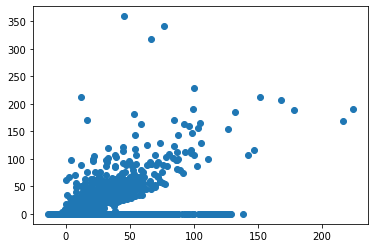

In [55]:
plt.scatter(y_test_pred, y_test)

In [67]:
joblib.dump(aml, 'Model/pickles_files/200104/fitted_selected_features_h2o_model.pkl')

['Model/pickles_files/191123/fitted_all_features_h2o_model.pkl']

In [ ]:
# read h2o dump file
h2o.load_model('Model/pickles_files/200104/fitted_selected_features_h2o_model.pkl')

### とりあえずRFで結果を出力する機構を作成する

#### Fit by all features

In [56]:
rf_reg = RandomForestRegressor(
    n_estimators=1000, 
    max_depth = 10, 
    max_features = 'sqrt', 
    n_jobs=-1, 
    verbose=1
)

In [57]:
rf_reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [58]:
feature_importance = pd.DataFrame(rf_reg.feature_importances_, columns=["importance"], index=feature_cols)
feature_importance.sort_values("importance", ascending=False)

,importance
win_odds,0.051075
href_to_jockey,0.032885
href_to_owner,0.031576
popularity_order,0.026252
href_to_horse,0.026157
MEAN(race_past_x.arrival_sec_diff_from_first),0.021418
SUM(race_past_x.arrival_sec_diff_from_first),0.021216
SKEW(race_past_x.arrival_sec_diff_from_first),0.020732
SUM(race_past_x.past_x_arrival_order),0.020283
MIN(race_past_x.arrival_sec_diff_from_first),0.019831


In [59]:
y_test_pred = rf_reg.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test_pred, y_test)))
print('R2: ', r2_score(y_test_pred, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished


RMSE:  8.41878388870833
R2:  -388.2876266072358


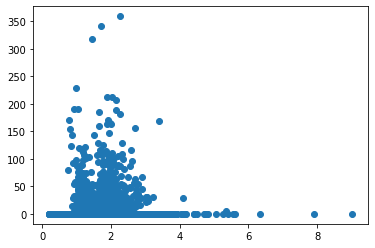

In [60]:
plt.scatter(y_test_pred, y_test)

#### Fit by selected features

In [63]:
rf_reg = RandomForestRegressor(
    n_estimators=1000, 
    max_depth = 10, 
    max_features = 'sqrt', 
    n_jobs=-1, 
    verbose=1
)

In [64]:
rf_reg.fit(X_train_selected, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [65]:
y_test_pred = rf_reg.predict(X_test_selected)
print('RMSE: ', np.sqrt(mean_squared_error(y_test_pred, y_test)))
print('R2: ', r2_score(y_test_pred, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished


RMSE:  8.525827248501933
R2:  -6.139714003228044


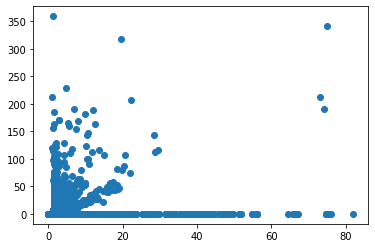

In [66]:
plt.scatter(y_test_pred, y_test)

### ここまでがRFによるもの

In [ ]:
predited_score_df = pd.concat(
    [Idx_test.reset_index(drop=True), pd.DataFrame(np.round(y_test_pred, 3), columns=['predicted_score'])], axis=1
)

In [ ]:
predited_score_df.head(10)

In [ ]:
predited_score_list = predited_score_df.values.tolist()

In [ ]:
def _bulk_insert(insert_list, target_table_name, insert_col_names):
    try:
        bi = BulkInsert(con)
        bi.execute(insert_data=insert_list, target_table=target_table_name, col_names=insert_col_names)
    except RuntimeError as e:
        print(e)
        raise TypeError

In [ ]:
_bulk_insert(predited_score_list, 'race_predicted_score', parameters['TABLE_COL_NAMES']['race_predicted_score'])

#### Profiling to check finally

In [ ]:
# import pandas_profiling as pdp
# profile = pdp.ProfileReport(training_race_df)
# profile.to_file(output_file="Model/profile_report.html")
# profile